# Trying BarlowTwins on CIFAR-10

In [8]:
! git pull

Updating 9e2ece3..af9f4c2
error: Your local changes to the following files would be overwritten by merge:
	BarlowTwins_CIFAR10.ipynb
Please commit your changes or stash them before you merge.
Aborting


In [1]:
from os import makedirs

import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

from torchvision.models import resnet18

from models import BarlowTwins
#from optimizer import LARS
from trainer import SSL_Trainer
from utils import SSL_CIFAR10

# Define hyperparameters
data_root = '/home/space/datasets/'
#data_root = '/home/fcfschulz/Documents/workspace/data/Vision/'
save_root = './results/barlow_twins/'

dl_kwargs = {'batch_size': 512, 'shuffle': True, 'num_workers': 2}

# Define data
ssl_data = SSL_CIFAR10(data_root,'BYOL', dl_kwargs)

train_params = {'save_root': save_root, 'num_epochs': 10, 'optimizer': SGD,
                'scheduler': CosineAnnealingLR, 'warmup_epochs': 5, 'iter_scheduler':True,
                'evaluate_at': [100,200,400,600], 'verbose':True}

## In Original Paper for Imagenet when using LARS Optimizer
#optim_params = {'lr':0.2 * dl_kwargs['batch_size']/256, 'weight_decay': 1.5e-6,
#                'exclude_bias_and_norm': True}
optim_params = {'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 5e-4} # from here: https://github.com/IgorSusmelj/barlowtwins/blob/main/main.py

scheduler_params = {'T_max': (train_params['num_epochs']-train_params['warmup_epochs'])*len(ssl_data.train_dl)}
                    # 'eta_min': 1e-3} in orginal implementation

eval_params  = {'lr':1e-2, 'num_epochs': 25, 'milestones': [12,20]}

# Get device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Print Device Type
if torch.cuda.is_available():
    print(f"Program running on {torch.cuda.get_device_name(device)}")
else:
    print("Program running on CPU")
    
# Create folder if it does not exists
makedirs(save_root, exist_ok=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Program running on Tesla P100-PCIE-12GB


# BarlowTwins

In [2]:
# Define Model
resnet = resnet18(zero_init_residual=True)

barlow_twins = BarlowTwins(resnet, projector_hidden = (2048,2048,2048)).to(device)

# Define Trainer
cifar10_trainer = SSL_Trainer(barlow_twins, ssl_data, device)

# Train
cifar10_trainer.train(**train_params, optim_params=optim_params,
                      scheduler_params=scheduler_params, eval_params=eval_params)

Pretrained model available, use it?[y/n]: n


/home/fcfschulz/miniconda3/envs/pg_high/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, Loss: 1397.6592149242913, Time epoch: 72.78435158729553
Epoch: 1, Loss: 1211.319455490899, Time epoch: 70.08806228637695
Epoch: 2, Loss: 1112.6538815842462, Time epoch: 69.86186289787292
Epoch: 3, Loss: 1021.7876291176708, Time epoch: 70.06160426139832
Epoch: 4, Loss: 985.051998806983, Time epoch: 69.68298411369324
Epoch: 5, Loss: 974.7971474559037, Time epoch: 70.09600067138672
Epoch: 6, Loss: 958.012158580662, Time epoch: 69.36627459526062
Epoch: 7, Loss: 932.162353515625, Time epoch: 69.64225339889526
Epoch: 8, Loss: 877.0895561926144, Time epoch: 69.30090665817261
Epoch: 9, Loss: 836.8962685496537, Time epoch: 69.4221875667572
Accuracy after full Training: KNN:44.95, Linear: 50.78


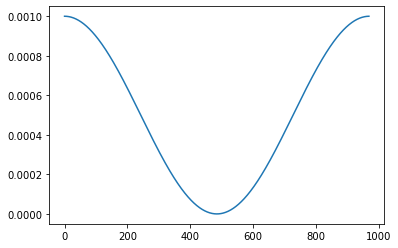

In [3]:
import matplotlib.pyplot as plt

plt.plot(cifar10_trainer._hist_lr);

In [4]:
(train_params['num_epochs']-train_params['warmup_epochs'])*len(ssl_data.train_dl)

485

In [5]:
10*len(ssl_data.train_dl)

970